# **0. 라이브러리 import**

이번 과제는 self-supervised 모델과, 그냥 CNN 모델을 비교하는 과제이다. 이를 위해 필요한 라이브러리들은 다음과 같다.

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# **1. 데이터 전처리**

데이터 전처리 과정은 다음과 같다. label data와 simclr 데이터에 다른 tranform 을 적용해야 하기 때문에 따로 data transform을 2개 구현했다. 아래 코드는 효빈이 제출본을 가져와서 사용했는데 그 이유는 다음과 같다.

나는 모델 내부에서 transform 을 하려고 했지만, 그렇게 하면 매 image 마다 transform을 호출해 학습 시간이 너무 오래걸리는 문제가 있어 보였다. 그래서 tranform 을 dataset 구축할 때 해주어야 한다고 생각해서 효빈의 코드를 참고했다.

In [42]:
transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_unlabeled = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class CustomSubset(Dataset):
    def __init__(self, dataset, indices, transform1=None, transform2=None):
        self.dataset = dataset
        self.indices = indices
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]

        if self.transform1:
            img1 = self.transform1(img)
        if self.transform2:
            img2 = self.transform2(img)

        if self.transform2 != None:
            return img1, img2
        else:
            return img1, label

    def __len__(self):
        return len(self.indices)


def stratified_sampling(dataset, labeled_ratio=0.1):
    labels = np.array(dataset.targets)
    train_indices, _ = train_test_split(
        np.arange(len(dataset)), stratify=labels, train_size=labeled_ratio, random_state=42
    )
    return train_indices

def get_cifar100_dataloaders(batch_size=128, labeled_ratio=0.1):
    dataset = datasets.CIFAR100(root='./data', train=True, download=True)
    test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_labeled)

    labeled_indices = stratified_sampling(dataset, labeled_ratio)
    unlabeled_indices = np.setdiff1d(np.arange(len(dataset)), labeled_indices)

    labeled_dataset = CustomSubset(dataset, labeled_indices, transform_labeled)
    unlabeled_dataset = CustomSubset(dataset, unlabeled_indices, transform_unlabeled, transform_unlabeled)

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader

In [44]:
# def get_cifar100_dataloaders(label_ratio=0.1, batch_size=128):
#     base_transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomCrop(32, padding=4),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     simclr_transform = transforms.Compose([
#         transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([
#             transforms.ColorJitter(0.4, 0.4, 0.4, 0.4)
#         ], p=0.8),
#         transforms.RandomGrayscale(p=0.2),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=None)
#     test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=base_transform)

#     num_labeled = int(len(dataset) * label_ratio)
#     indices = np.random.permutation(len(dataset))
#     labeled_idx, unlabeled_idx = indices[:num_labeled], indices[num_labeled:]

#     labeled_dataset = TransformSubset(Subset(dataset, labeled_idx), transform=base_transform)
#     unlabeled_dataset = TransformSubset(Subset(dataset, unlabeled_idx), transform=simclr_transform)

#     labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
#     unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     return labeled_loader, unlabeled_loader, test_loader


# **3. 시각화**

각 train의 loss curve 를 보기 위해 시각화 코드를 만들었다. 매 step 마다 저장한 loss 와 accuracy를 바탕으로 plot 그래프를 만든다.

In [45]:
# 훈련 과정 시각화를 위한 리스트
def plot_training(history, title):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label='Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], label='Accuracy', marker='o', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.show()

# **4. 학습 코드**

resnet은 torchvision 에 구현되어 있는 resnet 18 을 가져와서 학습했으며, data는 cifar-100 의 10%로 구성되어 있다.

simclr 은 unlabeled data를 가져와서 대조학습을 진행하고 이후에 labeled 데이터를 가지고 finetuning 을 하는 방법을 택했다.

이 방법 외에도 simclr 내부에 매 step label 데이터를 기반으로 학습을 도울 수 있는 방법도 있지만, finetune 하는 것이 제일 일반적인 방법이라 생각해 이 방법을 택했다.

In [46]:
# ResNet 학습
def train_resnet(labeled_loader, num_classes=100, epochs=50, lr=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for inputs, targets in labeled_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(labeled_loader)
        accuracy = 100. * correct / total
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)

        print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    plot_training(history, "ResNet Training")
    return model

In [47]:
# SimCLR Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, hidden_dim=256, out_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [48]:
# NT-Xent Loss (SimCLR의 핵심 손실 함수)
def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)
    z = F.normalize(z, dim=1)

    similarity_matrix = torch.matmul(z, z.T) / temperature
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0).to(z.device)

    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z.device)
    similarity_matrix = similarity_matrix[~mask].view(labels.shape[0], -1)

    positives = similarity_matrix[:, batch_size - 1]
    negatives = similarity_matrix[:, batch_size:]

    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z.device)

    return F.cross_entropy(logits, labels)

In [49]:
def get_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(30),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [50]:
# SimCLR 학습
def train_simclr(unlabeled_loader, num_epochs=50, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ResNet Backbone + Projection Head
    backbone = models.resnet18(pretrained=False)
    backbone.fc = nn.Identity()
    model = nn.Sequential(backbone, ProjectionHead()).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    history = {'loss': []}

    transform = get_transforms()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for img1, img2 in unlabeled_loader:
            inputs1, inputs2 = img1.to(device), img2.to(device)

            optimizer.zero_grad()

            z1, z2 = model(inputs1), model(inputs2)
            loss = nt_xent_loss(z1, z2)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(unlabeled_loader)
        history['loss'].append(avg_loss)

        print(f"SimCLR Epoch {epoch+1}: Loss: {avg_loss:.4f}")

    plot_training({'loss': history['loss'], 'accuracy': [0]*len(history['loss'])}, "SimCLR Training")
    return backbone  # Projection Head 없이 Feature Extractor만 반환

In [51]:
# SimCLR Fine-Tuning
def fine_tune_simclr(model, labeled_loader, num_classes=100, epochs=50, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.fc = nn.Linear(512, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for inputs, targets in labeled_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(labeled_loader)
        accuracy = 100. * correct / total
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)

        print(f"Fine-Tuning Epoch {epoch+1}: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    plot_training(history, "Fine-Tuning SimCLR")
    return model

In [54]:
# 데이터 로드
labeled_loader, unlabeled_loader, test_loader = get_cifar100_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# SimCLR 학습 (시각화 포함)
simclr_model = train_simclr(unlabeled_loader)

Fine-Tuning Epoch 1: Loss: 4.4245, Accuracy: 3.36%
Fine-Tuning Epoch 2: Loss: 4.0871, Accuracy: 6.70%
Fine-Tuning Epoch 3: Loss: 3.8450, Accuracy: 9.72%
Fine-Tuning Epoch 4: Loss: 3.6328, Accuracy: 13.16%
Fine-Tuning Epoch 5: Loss: 3.5567, Accuracy: 14.44%
Fine-Tuning Epoch 6: Loss: 3.2897, Accuracy: 19.06%
Fine-Tuning Epoch 7: Loss: 3.1739, Accuracy: 20.42%
Fine-Tuning Epoch 8: Loss: 3.0248, Accuracy: 24.62%
Fine-Tuning Epoch 9: Loss: 2.8012, Accuracy: 28.36%
Fine-Tuning Epoch 10: Loss: 2.6254, Accuracy: 31.38%
Fine-Tuning Epoch 11: Loss: 2.4914, Accuracy: 34.40%
Fine-Tuning Epoch 12: Loss: 2.3487, Accuracy: 38.38%
Fine-Tuning Epoch 13: Loss: 2.2657, Accuracy: 39.80%
Fine-Tuning Epoch 14: Loss: 2.0492, Accuracy: 45.24%
Fine-Tuning Epoch 15: Loss: 1.9116, Accuracy: 48.48%
Fine-Tuning Epoch 16: Loss: 1.8005, Accuracy: 52.18%
Fine-Tuning Epoch 17: Loss: 1.5916, Accuracy: 57.40%
Fine-Tuning Epoch 18: Loss: 1.5088, Accuracy: 59.14%
Fine-Tuning Epoch 19: Loss: 1.3998, Accuracy: 61.86%
Fine-

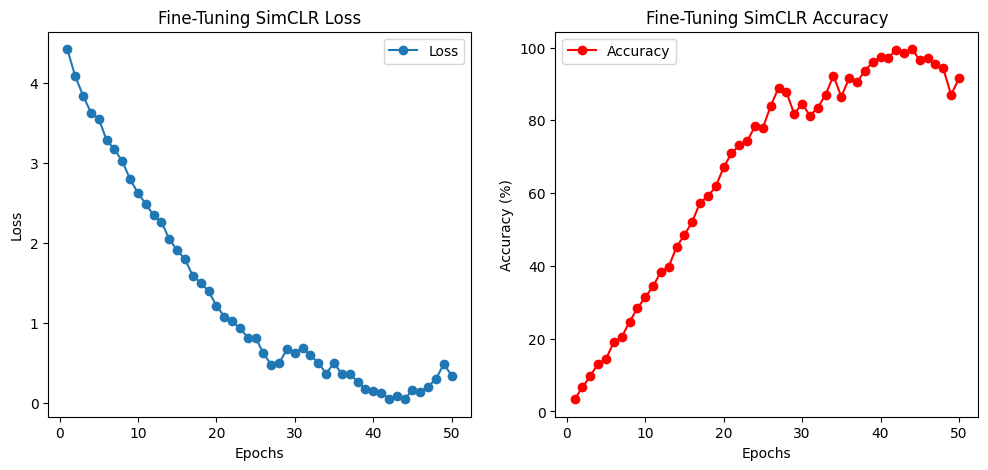

In [56]:
# Fine-Tuning SimCLR (시각화 포함)
fine_tuned_simclr = fine_tune_simclr(simclr_model, labeled_loader)

Epoch 1: Loss: 5.0021, Accuracy: 2.92%
Epoch 2: Loss: 4.6542, Accuracy: 3.80%
Epoch 3: Loss: 4.3746, Accuracy: 4.24%
Epoch 4: Loss: 4.2080, Accuracy: 5.10%
Epoch 5: Loss: 4.1513, Accuracy: 6.24%
Epoch 6: Loss: 4.1263, Accuracy: 6.24%
Epoch 7: Loss: 3.9547, Accuracy: 8.30%
Epoch 8: Loss: 3.9290, Accuracy: 8.28%
Epoch 9: Loss: 3.8338, Accuracy: 9.20%
Epoch 10: Loss: 3.8795, Accuracy: 9.38%
Epoch 11: Loss: 3.7300, Accuracy: 10.92%
Epoch 12: Loss: 3.7498, Accuracy: 10.76%
Epoch 13: Loss: 3.6628, Accuracy: 11.84%
Epoch 14: Loss: 3.5773, Accuracy: 12.76%
Epoch 15: Loss: 3.5793, Accuracy: 14.16%
Epoch 16: Loss: 3.4985, Accuracy: 14.66%
Epoch 17: Loss: 3.4430, Accuracy: 15.70%
Epoch 18: Loss: 3.3758, Accuracy: 16.26%
Epoch 19: Loss: 3.3667, Accuracy: 17.12%
Epoch 20: Loss: 3.3285, Accuracy: 17.30%
Epoch 21: Loss: 3.2272, Accuracy: 18.92%
Epoch 22: Loss: 3.2915, Accuracy: 19.16%
Epoch 23: Loss: 3.2543, Accuracy: 18.56%
Epoch 24: Loss: 3.0826, Accuracy: 21.54%
Epoch 25: Loss: 3.0554, Accuracy: 2

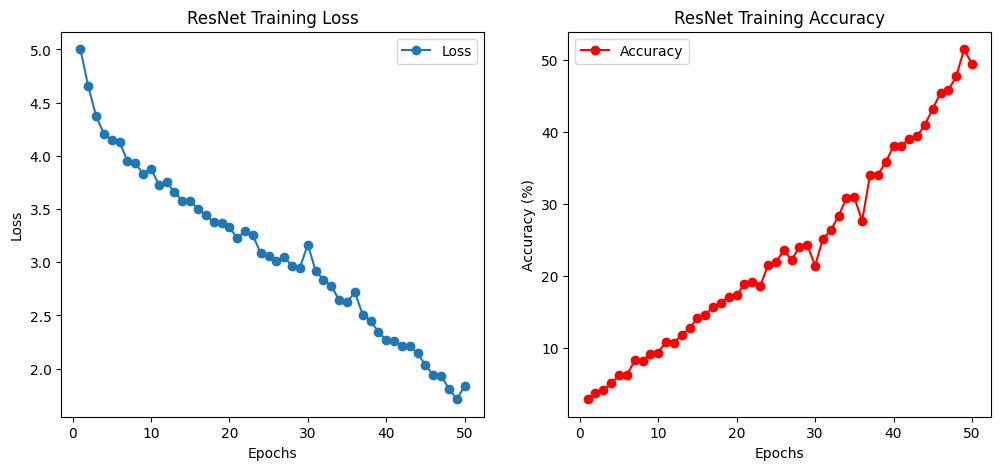

In [35]:
# ResNet 학습 (시각화 포함)
resnet_model = train_resnet(labeled_loader)

# **결과 분석 및 미흡한점**


결과 분석

loss curve 및 accuracy curve 를 보면 알 수 있듯, simclr 기반의 대조학습을 진행한 모델이 그냥 처음부터 실행한 모델보다는 훨씬 빠른 속도로 수렴하며, 그 성능또한 뛰어남을 볼 수 있다. 그 이유는 당연히 대조학습을 통한 weight initalize 가 큰 역할을 했다고 볼 수 있을 것 같다. simclr 과 같은 self-supervised 방식은 image에 대한 구조적인 특성을 보다 잘 파악할 수 있기 때문에 도움이 된 것 같다. 다만 아쉽게도 런타임 끊겨, test data에 대한 결과 비교는 할 수 없었는데, 이는 다음에 다시 확인해야 할 것 같다.

미흡한점

지금은 런타임이 끊겨 확인할 수 없지만, simclr 의 loss가 잘 떨어지지 않는 것을 볼 수 있었는데, 구현이 잘못되었는지, 하이퍼 파라미터를 잘 못 설정했는지 그 이유는 아직 잘 모르겠지만, 그럼에도 불구하고 fine tuneing 시 매우 빠른 수렴속도를 보여줘서 잘된건가 싶기도 하다. 이 과제를 진행하면서 내가 simclr을 정확히 알고 있다고 생각했지만, 구현을 고민하는 것을 보니 아직 잘 모르는 구나 라는 생각을 했다. 그래서 일단 인공지능 최신기술 수업에서 self-supervised 구현을 반학기동안 배우기 때문에, 이를 습득한 후 업데이트를 진행하려고 한다. 업데이트시에는 ssl, semi-sl, sl 을 전부 비교해보려고 한다.

결론

정확한 결과인지 매우 의심되지만, 이 실험 결과로 부터 얻을 수 있는 것은 지금과 같이 cifar-100 의 10%만 사용할 수 있듯 매우 작은 데이터 셋이 있는 경우에, 대조학습을 통한 가중치를 가져와서 학습을 하는 것이 매우 큰 도움이 된다는 것을 알았으며, self-supervised가 필요한 이유에 대해서 배울 수 있는 과제 였던 것 같다. 반드시 simclr 의 구현을 다시 해볼 것을 다짐한다.